# TAIL-RISK FUND: OPTIONS

author: [@sparshsah](https://github.com/sparshsah)

ref: https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/tail-risk-fund.md

In [87]:
from __future__ import annotations

import numpy as np
import pandas as pd

# https://github.com/sparshsah/foggy-statslib
import sys; sys.path.append("../../../foggy-statslib/")
import foggy_statslib.core as fsc
import foggy_statslib.fin as fsf

# EXPLORE

## Setting

You hold one share of S, which is currently trading at 100USD.
(S is SPX, but I don't want the fact that SPX is not tradable and also actually at 3000USD to distract you.)

You believe that it is equally likely to:
1. Fall 20pct over the next 6 months (accompanied by a doubling in ivols), Then stay flat to EOY
2. Stay flat over the next 6 months, Then fall 20pct by EOY
3. Stay flat through EOY

Prevailing option-implied vols are around 16pct,
and for simplicity neglect (a) volatility smirks, (b) the risk-free rate, and (c) tcosts.

Crucially: Unlike most single-name equity options which are American-style, the SPX-like index options we consider are European-style.

In [32]:
sigma: Final[float] = 0.16
r: Final[float] = 0

## Question

Should you
* A: Purchase a 2-quarter put (rolling into another one if the crash fails to materialize by expiry)?
* B: Purchase a 4-quarter put?
* C: Buy "half" of each strategy?

Assuming you fix your strike at 90USD.
Assume also that you finance your puts with borrowing (not selling shares).

In [48]:
init_value_of_one_put_a = fsf.calc_bsf_option_value(
    tau=2/4,
    K=90,
    S_t=100,
    sigma=sigma,
    r=r,
    put=True,
)
init_value_of_one_put_b = fsf.calc_bsf_option_value(
    tau=4/4,
    K=90,
    S_t=100,
    sigma=sigma,
    r=r,
    put=True,
)
print(f"Premium for each Put: A = ${init_value_of_one_put_a:.2f}, B = ${init_value_of_one_put_b:.2f}.")

Premium for each Put: A = $1.02, B = $2.32.


In [64]:
# dollar return under each scenario of different strategies, by quarter

# SCENARIO 1: S falls -20% over the next 6 months, then stays flat to EOY
r1 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: -20,
            3: 0,
            4: 0,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # you would exercise, earning $10
            2: +10,
            3: 0,
            4: 0,
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now more valuable! thanks to the price crash and associated vol spike.
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=80,  # down from 100
                    sigma=2*sigma,  # doubled
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # now there's no more activity, as you sold your put once you observed the crash
            3: 0,
            4: 0,
        },
    }
)
r1.loc[:, "c"] = r1[["a","b"]].mean(axis="columns")
r1.loc["=>", :] = r1.sum()


# SCENARIO 2: S stays flat over the next 6 months, then drops -20% by EOY
r2 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: -20,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            2: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # on top of that, you're back to the start: you must now buy a new one (financed with borrowing)
                # Notice: Nothing has changed about the market.
                + (init_value_of_one_put_a - init_value_of_one_put_a)
            ),
            3: (
                # your SECOND put is now again less valuable, as a quarter passes with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # sweet payoff
            4: +10,
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now EVEN less valuable, as ANOTHER quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # rinse and repeat
            3: (
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                - fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # sweet payoff
            4: +10,
        },
    }
)
r2.loc[:, "c"] = r2[["a","b"]].mean(axis="columns")
r2.loc["=>", :] = r2.sum()

# SCENARIO 3: S stays flat through EOY
r3 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 0,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            2: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # on top of that, you're back to the start: you must now buy a new one (financed with borrowing)
                # Notice: Nothing has changed about the market.
                + (init_value_of_one_put_a - init_value_of_one_put_a)
            ),
            3: (
                # your SECOND put is now again less valuable, as a quarter passes with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # sweet payoff
            4: (
                # your SECOND put is now again worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now EVEN less valuable, as ANOTHER quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # rinse and repeat
            3: (
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                - fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            4: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            )
        },
    }
)
r3.loc[:, "c"] = r3[["a","b"]].mean(axis="columns")
r3.loc["=>", :] = r3.sum()

In [65]:
r1

,principal,a,b,c
0,0.0,0.00000,0.000000,0.000000
1,0.0,-0.68351,-0.629979,-0.656744
2,-20.0,10.00000,11.974178,10.987089
3,0.0,0.00000,0.000000,0.000000
4,0.0,0.00000,0.000000,0.000000
=>,-20.0,9.31649,11.344199,10.330345


In [66]:
r2

,principal,a,b,c
0,0.0,0.000000,0.000000,0.000000
1,0.0,-0.683510,-0.629979,-0.656744
2,0.0,-0.333041,-0.674634,-0.503837
3,0.0,-0.683510,-0.683510,-0.683510
4,-20.0,10.000000,10.000000,10.000000
=>,-20.0,8.299940,8.011877,8.155909


In [67]:
r3

,principal,a,b,c
0,0.0,0.000000,0.000000,0.000000
1,0.0,-0.683510,-0.629979,-0.656744
2,0.0,-0.333041,-0.674634,-0.503837
3,0.0,-0.683510,-0.683510,-0.683510
4,0.0,-0.333041,-0.333041,-0.333041
=>,0.0,-2.033100,-2.321164,-2.177132


In [68]:
# check: total should be equal to the accumulated option premia
2*init_value_of_one_put_a, init_value_of_one_put_b

(2.0331002120362314, 2.3211635243986244)

# BHANSALI

Trying Bhansali 2014's "active" strategy

In [174]:
NAV: Final[float] = 1e9
START_DATE: Final[str] = "2015-01-01"
MONEYNESS: Final[float] = -0.05
# annualized
_BUDGET: Final[float] = 0.01
# q'tly
BUDGET: Final[float] = NAV * _BUDGET / 4

In [149]:
def get_stock_px(ticker: str = "COF", start_date: str = START_DATE) -> pd.Series[float]:
    # underlying
    stock_px = pd.read_csv(
        f"data/yahoo-finance_NYSE-{ticker}_px.csv",
        index_col="Date",
        parse_dates=True,
    )["Adj Close"].rename("stock_px").loc[start_date:]
    dtx = pd.date_range(
        start=stock_px.index[0],
        end=stock_px.index[-1],
        freq="B",
        name="date",
    )
    stock_px = stock_px.reindex(index=dtx).ffill()
    return stock_px

def _get_r(stock_px: pd.Series[float]) -> pd.Series[float]:
    return stock_px/stock_px.shift() -1

def _get_vol(r: pd.Series[float], window: int = 65) -> pd.Series[float]:
    return (
        r
        .rolling(window=window, min_periods=round(0.95*window))
        .std()
        .ffill()
        # backfill the first `window` days... bc whatever
        .bfill()
    # annualize
    ) * 261**0.5

def get_ivol(stock_px: pd.Series[float], vrp_mult: float=1.05) -> pd.Series[float]:
    r = _get_r(stock_px=stock_px)
    vol = _get_vol(r=r)
    ivol = vrp_mult * vol
    return ivol

stock_px = get_stock_px()
ivol = get_ivol(stock_px=stock_px)

In [150]:
xdates = pd.date_range(
    start=stock_px.index[0],
    end=stock_px.index[-1],
    freq="BQ",
    name="expiration_dates",
)
assert not len(xdates.difference(stock_px.index)), xdates.difference(stock_px.index)
xdates

DatetimeIndex(['2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-30',
               '2017-03-31', '2017-06-30', '2017-09-29', '2017-12-29',
               '2018-03-30', '2018-06-29', '2018-09-28', '2018-12-31',
               '2019-03-29', '2019-06-28', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-30',
               '2023-03-31', '2023-06-30', '2023-09-29'],
              dtype='datetime64[ns]', name='expiration_dates', freq='BQ-DEC')

In [267]:
def _get_put_params(
    stock_px: pd.Series[float],
    ivol: pd.Series[float],
    xdates: pd.DatetimeIndex,
    moneyness: float = MONEYNESS,
) -> pd.Series[int]:
    params = pd.DataFrame({"stock_px": stock_px, "ivol": ivol})
    is_xdate = params.index.isin(xdates)

    # origination date
    params.loc[:, "odate"] = pd.Series(index=xdates, data=xdates).reindex(index=stock_px.index).ffill()
    # fill in initial, but black out post-final
    params.loc[:xdates[0], "odate"] = stock_px.index[0]
    params.loc[xdates[-1]:, "odate"] = np.nan
    # IRL, odate will be day _after_ xdate...
    params.loc[:, "odate"] += pd.offsets.BDay()
    # ... except on the xdate itself, when we should carry forward the previous odate
    params.loc[is_xdate, "odate"] = params["odate"].shift().loc[is_xdate]

    # expiration date
    params.loc[:, "xdate"] = pd.Series(index=xdates, data=xdates).reindex(index=stock_px.index).bfill()

    # days to expiration
    params.loc[:, "dte"] = pd.Series(
        index=params["xdate"].dropna().index,
        data=np.busday_count(
            [
                d for d in
                params["xdate"].dropna().index.map(
                    lambda dt: dt.date()
                )
            ],
            [
                d for d in
                params["xdate"].dropna().map(
                    lambda dt: dt.date()
                )
            ],
        ),
    )
    # floor to make well-behaved at 0DTE
    params.loc[:, "yte"] = params["dte"].clip(lower=0.01)/261

    params.loc[:, "strike"] = params["odate"].map(stock_px) * (1+moneyness)
    # fill in initial, but black out post-final
    params.loc[:xdates[0], "strike"] = stock_px.iloc[0] * (1+moneyness)
    params.loc[xdates[-1]:, "strike"] = np.nan

    # ok whew
    params.loc[:, "put_value"] = params.apply(
        lambda row: fsf.calc_bsf_option_value(
            tau=row["yte"],
            K=row["strike"],
            S_t=row["stock_px"],
            sigma=row["ivol"],
            r=0.05,
            put=True,
        ),
        axis="columns",
    )
    params.loc[:, "upfront_premium"] = params["odate"].map(params["put_value"])
    params.loc[:, "period_cum_pnl"] = params["put_value"] - params["upfront_premium"]
    params.loc[:, "period_cum_pnl_if_xdate"] = params["period_cum_pnl"] * is_xdate
    params.loc[:, "n"] = BUDGET / params["upfront_premium"]
    return params

In [268]:
params = _get_put_params(stock_px,ivol, xdates)
params

/var/folders/j1/k5f4073s6wj4tz_zy4ts1l0r0000gn/T/ipykernel_6837/2213610701.py:16: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  params.loc[:, "odate"] += pd.offsets.BDay()


,stock_px,ivol,odate,xdate,dte,yte,strike,put_value,upfront_premium,period_cum_pnl,period_cum_pnl_if_xdate,n
date,,,,,,,,,,,,
2015-01-02,69.560104,0.222506,2015-01-05,2015-03-31,62.0,0.237548,66.082099,1.267288,1.728494,-0.461206,-0.0,1.446346e+06
2015-01-05,67.957916,0.222506,2015-01-05,2015-03-31,61.0,0.233716,66.082099,1.728494,1.728494,0.000000,0.0,1.446346e+06
2015-01-06,66.693039,0.222506,2015-01-05,2015-03-31,60.0,0.229885,66.082099,2.177637,1.728494,0.449144,0.0,1.446346e+06
2015-01-07,67.451973,0.222506,2015-01-05,2015-03-31,59.0,0.226054,66.082099,1.870222,1.728494,0.141728,0.0,1.446346e+06
2015-01-08,68.109688,0.222506,2015-01-05,2015-03-31,58.0,0.222222,66.082099,1.625903,1.728494,-0.102590,-0.0,1.446346e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,106.180000,0.316925,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-28,108.580002,0.317938,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-29,110.129997,0.318379,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


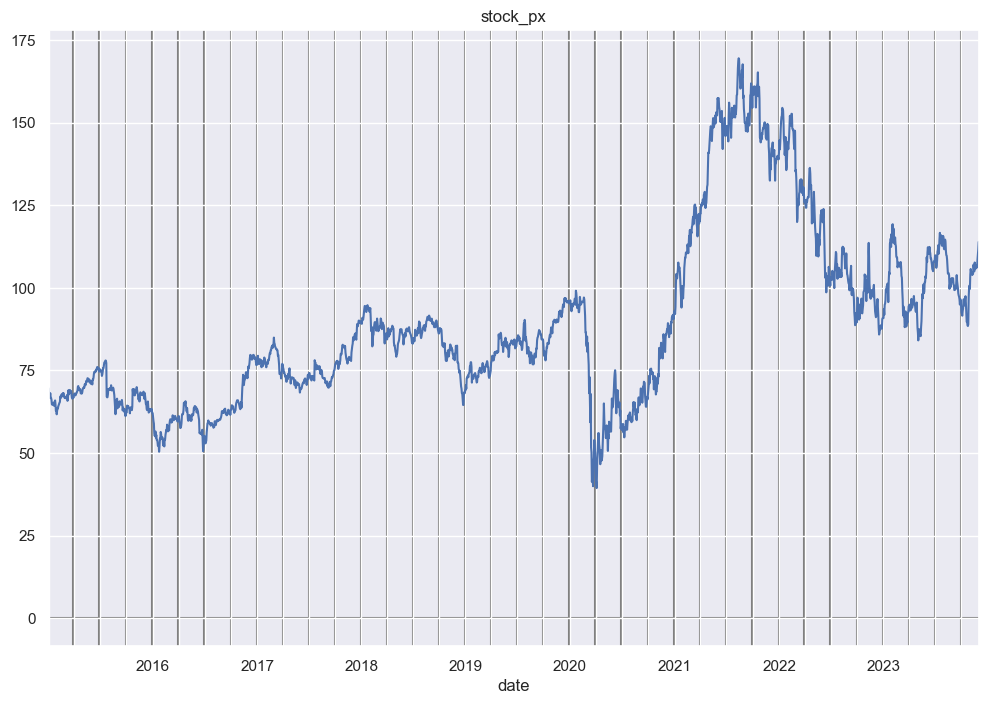

<Axes: title={'center': 'stock_px'}, xlabel='date'>

In [266]:
fsc.plot(
    stock_px,
    axvline_locs=xdates,
)

In [259]:
params.loc["2015-06-25":"2015-07-05"]

,stock_px,ivol,odate,xdate,is_xdate,dte,yte,strike,put_value,upfront_premium,period_cum_pnl,period_cum_pnl_if_takedate,n
date,,,,,,,,,,,,,
2015-06-25,75.588776,0.126104,2015-04-01,2015-06-30,False,3.0,0.011494,64.239183,5.421729e-35,1.265019,-1.265019,-0.000000,1.976255e+06
2015-06-26,75.767426,0.126106,2015-04-01,2015-06-30,False,2.0,0.007663,64.239183,2.282906e-52,1.265019,-1.265019,-0.000000,1.976255e+06
2015-06-29,74.652954,0.130447,2015-04-01,2015-06-30,False,1.0,0.003831,64.239183,2.730514e-79,1.265019,-1.265019,-0.000000,1.976255e+06
2015-06-30,74.840111,0.129719,2015-07-01,2015-06-30,True,0.0,0.000038,71.607294,0.000000e+00,0.389019,-0.389019,-0.389019,6.426415e+06
2015-07-01,75.376099,0.127892,2015-07-01,2015-09-30,False,65.0,0.249042,71.607294,3.890194e-01,0.389019,0.000000,0.000000,6.426415e+06
2015-07-02,75.137871,0.128032,2015-07-01,2015-09-30,False,64.0,0.245211,71.607294,4.210727e-01,0.389019,0.032053,0.000000,6.426415e+06
2015-07-03,75.137871,0.128032,2015-07-01,2015-09-30,False,63.0,0.241379,71.607294,4.143199e-01,0.389019,0.025301,0.000000,6.426415e+06


In [255]:
params.loc["2020-01-01":"2020-04-01"]

,stock_px,ivol,odate,xdate,is_xdate,dte,yte,strike,put_value,upfront_premium,period_cum_pnl,period_cum_pnl_if_takedate,n
date,,,,,,,,,,,,,
2020-01-01,95.565315,0.172736,2020-01-01,2020-03-31,False,64.0,0.245211,90.787049,1.050732e+00,1.050732,0.000000,0.000000,2.379293e+06
2020-01-02,96.215347,0.172140,2020-01-01,2020-03-31,False,63.0,0.241379,90.787049,8.960722e-01,1.050732,-0.154660,-0.000000,2.379293e+06
2020-01-03,94.720253,0.173723,2020-01-01,2020-03-31,False,62.0,0.237548,90.787049,1.229979e+00,1.050732,0.179246,0.000000,2.379293e+06
2020-01-06,93.865929,0.174700,2020-01-01,2020-03-31,False,61.0,0.233716,90.787049,1.454461e+00,1.050732,0.403728,0.000000,2.379293e+06
2020-01-07,92.937286,0.163896,2020-01-01,2020-03-31,False,60.0,0.229885,90.787049,1.546613e+00,1.050732,0.495880,0.000000,2.379293e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26,53.948269,0.992363,2020-01-01,2020-03-31,False,3.0,0.011494,90.787049,3.678662e+01,1.050732,35.735887,0.000000,2.379293e+06
2020-03-27,51.552429,0.995446,2020-01-01,2020-03-31,False,2.0,0.007663,90.787049,3.919984e+01,1.050732,38.149110,0.000000,2.379293e+06
2020-03-30,50.219337,0.996134,2020-01-01,2020-03-31,False,1.0,0.003831,90.787049,4.055032e+01,1.050732,39.499589,0.000000,2.379293e+06


In [242]:
params.loc["2015-03-31":"2015-06-30", "period_cum_pnl_if_takedate"]

date
2015-03-31   -1.267288
2015-04-01    0.000000
2015-04-02    0.000000
2015-04-03    0.000000
2015-04-06    0.000000
                ...   
2015-06-24   -0.000000
2015-06-25   -0.000000
2015-06-26   -0.000000
2015-06-29   -0.000000
2015-06-30    0.000000
Freq: B, Name: period_cum_pnl_if_takedate, Length: 66, dtype: float64

<Axes: xlabel='date'>

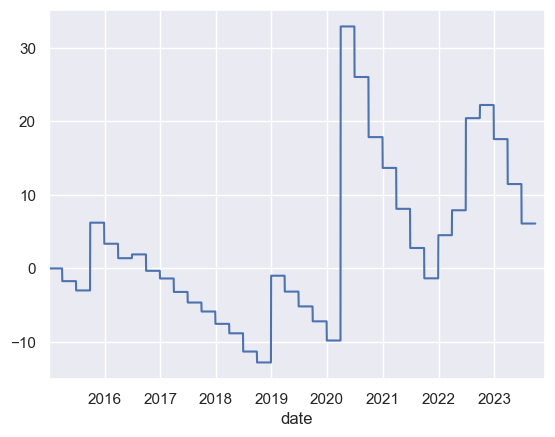

In [265]:
params["period_cum_pnl_if_takedate"].cumsum().plot()